### Authorship
@author: Alexandre Pereira Santos <br>
alexandre.santos(at)lmu.de<br>
- uses OSMNx, pandas, geopandas, rasterio
- may include content from ChatGPT or GitHub Copilot

### Roadmap
Prepare rasters as model inputs for the TI-City Model (see the [paper](http://journals.sagepub.com/doi/10.1177/23998083211068843) and [repo](https://github.com/skfagyemang/TI-City-Model) ):
1. Density
- Import [WorldPop](https://www.worldpop.org/) data (tip: use [Google Earth Engine](https://developers.google.com/earth-engine/datasets/catalog/WorldPop_GP_100m_pop#description) data at 100 m resolution)
- Calculate density
- Resample to 30 m resolution [currently done in ArcGIS Pro]
- Ressample and co-register to 30 m grid
- Export to ASCII format

2. Real estate prices
- Import real estate empirical data from [Le Petit et al. (2023)](https://linkinghub.elsevier.com/retrieve/pii/S235234092300080X)
- Select city in the AOI or clip to the AOI
- Interpolate point data [currently done in ArcGIS Pro, using [Empirical Bayesian Kriging](https://pro.arcgis.com/en/pro-app/latest/tool-reference/geostatistical-analyst/empirical-bayesian-kriging.htm)]
- Ressample and co-register to 30 m grid [currently done in ArcGIS Pro]
- Export to ASCII format

3. Built-up 2000 & built-up 2010
- Import [Global Urban Footprint](https://www.dlr.de/en/eoc/research-transfer/projects-missions/global-urban-footprint-guf) data
- Calculate distance raster
- Ressample and co-register to 30 m grid
- Export to ASCII format

4. Districts
- Rastrerize [GADM4](https://gadm.org/data.html) polygons
- Export to ASCII format

5. Tenure status
- There is no global dataset
- For the Mumbai case, import the  MMRDA 2016 slum clusters
- Convert to raster
- Ressample and co-register to 30 m grid
- Export to ASCII format

6. Exclusion layer
- Import water bodies from [HydroSHEDS](https://www.hydrosheds.org/)
- Convert to raster
- Ressample and co-register to 30 m grid
- Export to ASCII format

7. Attractiveness 2000 & 2020
- Calculate the centrality using [OSMnX](https://osmnx.readthedocs.io/en/stable/user-reference.html) data
- Select the top 15 percentile
- Calculate Euclidian distances to it
- Export to ASCII format

8. Calculate proximity using OSM data
- Fetch OSM data for health_facilities, schools, suburban_centres, shopping_malls, markets, airport, cbd
- Classify major features
- Rasterize and calculate Euclidian distance to major features
- Export to shapefile, TIFF and ASCII formats.

### Prerequisites
- AOI vector file (i.e., shapefile or geopackage)
- Raster reference file with the same extent as the AOI

# init

In [12]:
import pandas as pd
import geopandas as gpd
from matplotlib import pyplot as plt

from shapely.geometry.polygon import Polygon
from shapely.geometry.point import Point

from pathlib import Path
import numpy as np

import rasterio
from rasterio import features
from rasterio.plot import show
from scipy.ndimage import distance_transform_edt

import networkx as nx
import osmnx as ox

In [ ]:
def get_transform(raster):
    transform = raster.transform
    cell_width = transform[0]
    cell_height = -transform[4]
    area = cell_height*cell_width
    return cell_height, cell_width, area

# export raster as ascii files
# it requires the definition of a reference raster to copy the metadata
def export_raster_to_ascii(raster_obj, export_path, reference=ref_raster,raster_data_type=rasterio.int16):
    with rasterio.open(export_path, "w", driver='AAIGrid',
                    height = reference.shape[0], width=reference.shape[1],
                    count=1, dtype=raster_data_type,
                    crs=reference.crs, transform = reference.transform) as dest:
        dest.write(raster_obj.astype(raster_data_type), indexes=1)

def plot_ras_ras(raster1, raster2, title1='some data', title2='some data', AOI_gdf = None):
    fig, ax = plt.subplots(nrows=1, ncols = 2, figsize = (10, 10))
    '''if raster1.crs != None:
        AOI_gdf.to_crs(raster1.crs).plot(ax=ax[0],  alpha=0.5, color='lightgray', zorder=1)
        AOI_gdf.to_crs(raster2.crs).plot(ax=ax[1],  alpha=0.5, color='lightgray', zorder=1)
    else:'''
    
    AOI_gdf.plot(ax=ax[0],  alpha=0.5, color='lightgray', zorder=1)
    AOI_gdf.plot(ax=ax[1],  alpha=0.5, color='lightgray', zorder=1)

    show(raster1, ax = ax[0])
    show(raster2, ax = ax[1])

    ax[0].set_title(title1)
    ax[1].set_title(title2)

    plt.gca() 
    plt.show()

def plot_vec_vec_ras_ras(vector, dist_raster, norm_raster, title):
    fig, ax = plt.subplots(nrows=1, ncols = 4, figsize = (10, 40))
    vector.plot('major',ax=ax[0],color='grey', linewidth=1, zorder=1)
    vector.loc[vector.major==0].plot(ax=ax[1],color='lightgrey', zorder=3)
    vector.loc[vector.major==1].plot(ax=ax[1],color='tomato', zorder=4)
    AOI_gdf.plot(ax=ax[0],  alpha=0.5, color='lightgray', zorder=1)
    AOI_gdf.plot(ax=ax[1],  alpha=0.5, color='lightgray', zorder=1)
    show(dist_raster, ax = ax[2])
    show(norm_raster, ax = ax[3])

    ax[0].set_title('All '+ title + ' vector')
    ax[1].set_title('Major '+ title + ' vector')
    ax[2].set_title('Distance to \nmajor '+ title + ' (m)')
    ax[3].set_title('Distance to \nmajor '+ title + ' normalized')

    plt.gca() 
    plt.show()

def get_osm_features(tags, col_list, geom_type, major_dict, aoi):
    aoi_coords = aoi.to_crs(epsg='4326').envelope
    # updating the feature_from_bbox method to OSMnx 2 synthax. The old one (with north, south, east, and west) is deprecated.
    temp_places = ox.features_from_bbox(bbox=(aoi_coords.bounds.values[0][3], aoi_coords.bounds.values[0][1], aoi_coords.bounds.values[0][2], aoi_coords.bounds.values[0][0]),
                                        tags=tags)
    temp_places.reset_index(inplace=True)
    
    geom_list = []

    for feature in temp_places["geometry"]:
            if isinstance(feature, Polygon):
                    geom_list.append('Polygon')
            else:
                    geom_list.append('Point')
    
    if (geom_type == 'Mixed') & ('Polygon' in geom_list) & ('Point' in geom_list):
        temp_places["geometry"] = temp_places.centroid 
        temp_places = temp_places.loc[:, col_list]
        #temp_places.drop_duplicates('osmid',inplace=True)
        print('Attention: Mixed geometry types found, will be converted to points')
    else: 
          temp_places = temp_places.loc[(temp_places.geometry.type==geom_type), col_list]
    
    print('Features fetched',temp_places.shape[0])
    # filtering out the repeated entries
    temp_places.drop_duplicates('osmid', inplace=True) # the calls to drop_duplicates are separate to avoid getting the union of all conditions
    temp_places.drop_duplicates('geometry', inplace=True) # 
    temp_places.loc[temp_places['name'].notnull(),:].drop_duplicates('name', inplace=True) # 
    
    print('Features without duplicates',temp_places.shape[0])
    #convert the CRS of roads to the same as AOI
    temp_places.to_crs(aoi.crs,inplace=True)
    
    # clip features to the AOI
    places = gpd.clip(temp_places, mask=aoi, keep_geom_type=True)
    
    places['major'] = 0
    
    # identify major features based on the criteria dictionary
    for key, value in major_dict.items():
        places.loc[places[key].isin(value), 'major'] = 1
        #places.loc[(key == value), 'major'] = 1
        #places['major'] = places[key].apply(lambda x: 1 if x in value else None) #else 0

    return places

def get_distance_raster(gdf, ref_raster):

    # Filter major elments 
    major_gdf = gdf[gdf['major'] == 1]

    # Get the geometry of the major roads
    major_geom = [shapes for shapes in major_gdf.geometry]

    # Rasterize the major roads, script from https://pygis.io/docs/e_raster_rasterize.html
    major_raster = features.rasterize(major_geom,
                                    out_shape = ref_raster.shape,
                                    fill = 0,
                                    out = None,
                                    transform = ref_raster.transform,
                                    all_touched = True,
                                    default_value = 1,
                                    dtype = None)

    # Get the geometry of the all roads
    full_geom = [shapes for shapes in gdf.geometry]

    # Rasterize the all roads, script from https://pygis.io/docs/e_raster_rasterize.html
    full_raster = features.rasterize(full_geom,
                                    out_shape = ref_raster.shape,
                                    fill = 0,
                                    out = None,
                                    transform = ref_raster.transform,
                                    all_touched = True,
                                    default_value = 1,
                                    dtype = None)

    # Invert the raster: roads (value == 1) become 0, non-roads become 1
    inverted_raster = np.where(major_raster == 1, 0, 1)

    # Calculate the distance to the nearest road for each cell
    distance_raster = distance_transform_edt(inverted_raster)
    # Assuming the raster's resolution is in meters, the distance_to_roads array now contains the distance in meters to the nearest road for each cell
    
    # normalize the raster by the min-max method
    distance_raster_normalized = (distance_raster - np.nanmin(distance_raster))/(np.nanmax(distance_raster) - np.nanmin(distance_raster))
    
    # normalize the raster with the z-score method
    #distance_raster_normalized = (distance_raster - np.nanmean(distance_raster))/np.nanstd(distance_raster)

    return major_raster, full_raster, distance_raster, distance_raster_normalized

# export rasters as geotiff
# it requires the definition of a reference raster to copy the metadata
def export_raster(raster,url,data_type=rasterio.int16):
    with rasterio.open(
        url, "w",
        driver = "GTiff",
        crs = ref_raster.crs,
        transform = ref_raster.transform,
        dtype = data_type,
        count = 1,
        width = ref_raster.width,
        height = ref_raster.height) as dst:
        dst.write(raster, indexes = 1)

# export vector and raster files
def export_files(gdf, major_raster, full_raster, distance_raster, distance_normal, out_path, file_name='out_file'): #=interim_path
    gdf_vector_file = file_name + '.shp'
    gdf_url = out_path/gdf_vector_file
    gdf.to_file(gdf_url, driver='ESRI Shapefile')

    major_raster_file = file_name + '_major.tif'
    full_raster_file = file_name + '_all.tif'
    distance_raster_file = file_name + '_distance.tif'
    normalized_raster_file = file_name + '_distance_normal.tif'

    # export the calculated arrays as raster files in geotiff format
    
    distance_url = out_path/distance_raster_file
    normalized_url = out_path/normalized_raster_file
    major_url = out_path/major_raster_file
    full_url = out_path/full_raster_file

    export_raster(major_raster,major_url)
    export_raster(full_raster,full_url)
    export_raster(distance_raster,distance_url,rasterio.float32)
    export_raster(distance_normal,normalized_url,rasterio.float32)

    distance_ascii_url = out_path/(distance_raster_file.split('.')[0] + '.asc')
    major_ascii_url = out_path/(major_raster_file.split('.')[0] + '.asc')
    full_ascii_url = out_path/(full_raster_file.split('.')[0] + '.asc')
    normal_ascii_url = out_path/(normalized_raster_file.split('.')[0] + '.asc')

    # call the ASCII export function
    export_raster_to_ascii(major_raster, major_ascii_url,rasterio.int16)
    export_raster_to_ascii(full_raster, full_ascii_url,rasterio.int16)
    export_raster_to_ascii(distance_raster, distance_ascii_url,rasterio.float32)
    export_raster_to_ascii(distance_normal, normal_ascii_url,rasterio.float32)


# imports

In [13]:
#input a vector and a raster file for each city
AOI_path = Path('../data/processed/')
MUM_file = 'MUM_LIM_reference_AOI_30m.shp' # APS: updated AOI 01.08.2024
MAN_file = 'MAN_LIM_reference_AOI_30m.shp' # APS: updated AOI 09.09.2024
JAK_file = 'JAK_LIM_reference_AOI_30m.shp' # APS: updated AOI 23.08.2024

AOI_gdf = gpd.read_file(AOI_path / MUM_file) #.to_crs(epsg=4326)
MUM_AOI_gdf = gpd.read_file(AOI_path / MUM_file) 

ref_raster_path = Path('../data/processed/MUM_LIM_raster_reference_30m.tif') # you need to change this to your AOI

raw_path = Path(r'') # include your raw data path here
interim_path = Path(r'') # include your interim data path here
processed_path = Path(r'') # include your processed data path here
external_path = Path(r'') # include your external data path here
external_data_path = Path(r'') # include your other raw data path here (here I put global datasets, not exclusive to this project)

# read the reference raster
with rasterio.open(ref_raster_path,'r') as src:
    ref_raster = src
    ref_meta = src.meta
    ref_height, ref_width, ref_area = get_transform(ref_raster)

# suppress deprecation warnings
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

# Preparing rasters

## 1. Population density
- Import WorldPop data
- Calculate density
- Ressample and co-register to 30 m grid

### Downscaling the pop data from ca. 100 m to 30 m
Performin daysimetric mapping, as suggested in https://gis.stackexchange.com/questions/141763/after-turning-census-block-data-into-a-raster-how-do-i-redistribute-the-density
1. Create a density grid for the Census data by dividing each polygon's count by its area and converting that directly to raster format.
2. Create a relative density grid for the land cover data by joining the relative density table to the land cover type identifier.
3. Multiply the two grids (1) and (2).
4. Compute a zonal sum of the product in (3), using the Census regions as zones. Store this as a raster rather than a table.
5. Multiply (3) by the Census counts, divide by (4), and divide by the cell area.

In [4]:
# load population raster files 
with rasterio.open(interim_path / 'MUM_POP_population_2000_WDPop_WGS_90m.tif','r') as pop_raster_2000:
    pop_2000 = pop_raster_2000.read(1)
    # calculate the area of the pixels in the rasters using the afine information
    pop_raster_2000_height, pop_raster_2000_width, pop_raster_2000_area = get_transform(pop_raster_2000)
    # calculate the population density
    density_2000 = pop_2000 / pop_raster_2000_area
    # normalize the density
    density_2000_normal = np.round((density_2000 - np.nanmin(density_2000))/(np.nanmax(density_2000) - np.nanmin(density_2000)),4)
    density_2000_fill = np.where(np.isnan(density_2000_normal), 0, density_2000_normal)

with rasterio.open(interim_path / 'MUM_POP_population_2015_WDPop_WGS_90m.tif','r') as pop_raster_2015:
      pop_2015 = pop_raster_2015.read(1)
      # calculate the area of the pixels in the rasters using the afine information
      pop_raster_2015_height, pop_raster_2015_width, pop_raster_2015_area = get_transform(pop_raster_2015)
      # calculate the population density
      density_2015 = pop_2015 / pop_raster_2015_area
      # normalize the density
      density_2015_normal = np.round((density_2015 - np.nanmin(density_2015))/(np.nanmax(density_2015) - np.nanmin(density_2015)),4)
      density_2015_fill = np.where(np.isnan(density_2015_normal), 0, density_2015_normal)

print('Reference raster area',ref_area, 
      '\nPopulation 2000 raster area',pop_raster_2000_area, 
      '\nPopulation 2015 raster area',pop_raster_2015_area)



Reference raster area 900.0000000000013 
Population 2000 raster area 8097.401581887994 
Population 2015 raster area 8097.401581887994


In [9]:
# export density_2000_normal as a raster
data_type = rasterio.float32
raster = density_2000_normal
url = interim_path / 'MUM_POP_density_normal_2000_WDPop_90m.tif'

with rasterio.open(
    url, "w",
    driver = "GTiff",
    crs = pop_raster_2000.crs,
    transform = pop_raster_2000.transform,
    dtype = data_type,
    count = 1,
    width = pop_raster_2000.width,
    height = pop_raster_2000.height) as dst:
    dst.write(raster, indexes = 1)

In [10]:
# export density_2015_normal as a raster
data_type = rasterio.float32
raster = density_2015_normal
url = interim_path / 'MUM_POP_density_normal_2015_WDPop_90m.tif'

with rasterio.open(
    url, "w",
    driver = "GTiff",
    crs = pop_raster_2015.crs,
    transform = pop_raster_2015.transform,
    dtype = data_type,
    count = 1,
    width = pop_raster_2015.width,
    height = pop_raster_2015.height) as dst:
    dst.write(raster, indexes = 1)

### convert the externally resampled density 2000 raster to ASCII


In [11]:

with rasterio.open(interim_path/'MUM_POP_density_normal_2000_WDPop_30m.tif','r') as density_2000_30m:
  # exporting as ASCII
  raster_obj = density_2000_30m.read(1)
  export_path = interim_path/'MUM_POP_density_normal_2000_WDPop_30m.asc'
  ref_raster=ref_raster
  raster_data_type=rasterio.float32
  export_raster_to_ascii(raster_obj, export_path, ref_raster,raster_data_type)
      
with rasterio.open(interim_path/'MUM_POP_density_normal_2015_WDPop_30m.tif','r') as density_2015_30m:
  # exporting as ASCII
  raster_obj = density_2015_30m.read(1)
  export_path = interim_path/'MUM_POP_density_normal_2015_WDPop_30m.asc'
  ref_raster=ref_raster
  raster_data_type=rasterio.float32
  export_raster_to_ascii(raster_obj, export_path, ref_raster,raster_data_type)


In [15]:
# check if raster transformation makes sense

with rasterio.open(interim_path/'MUM_POP_density_normal_2015_WDPop_90m.tif','r') as density_2015_90m:
    with rasterio.open(interim_path/'MUM_POP_density_normal_2015_WDPop_30m.tif','r') as density_2015_30m:
      print('2015 raster check:',
         '\nRessampled mean raster density',np.nanmean(density_2015_90m.read(1)), 
         '\nOriginal mean raster density',np.nanmean(density_2015_30m.read(1)), 
         '\nOld cell size:',density_2015_90m.transform[0],'x',-density_2015_90m.transform[4],
         '\nNew cell size:',density_2015_30m.transform[0],'x',-density_2015_30m.transform[4])   

with rasterio.open(interim_path/'MUM_POP_density_normal_2000_WDPop_90m.tif','r') as density_2000_90m:
    with rasterio.open(interim_path/'MUM_POP_density_normal_2000_WDPop_30m.tif','r') as density_2000_30m:
      print('\n2000 raster check:',
         '\nRessampled mean raster density',np.nanmean(density_2000_90m.read(1)), 
            '\nOriginal mean raster density',np.nanmean(density_2000_30m.read(1)), 
            '\nOld cell size:',density_2000_90m.transform[0],'x',-density_2000_90m.transform[4],
            '\nNew cell size:',density_2000_30m.transform[0],'x',-density_2000_30m.transform[4])

2015 raster check: 
Ressampled mean raster density 0.042914256 
Original mean raster density 0.03543783 
Old cell size: 88.7176938369781 x 91.27155172413809 
New cell size: 29.99999999999999 x 30.000000000000053

2000 raster check: 
Ressampled mean raster density 0.035766628 
Original mean raster density 0.026901426 
Old cell size: 88.7176938369781 x 91.27155172413809 
New cell size: 29.99999999999999 x 30.000000000000053


## 2. Real estate prices
- Convert point data into raster
- Clip points to the AOI
- Interpolate to cover all AOI
- Ressample and co-register to 30 m grid
- Convert prices to USD

### Working with Lepetit et al. 2022 data

In [5]:
#import file to be clipped
real_estate_path = Path('\\WD Gridded Real Estate Population and Land Use Petit et al\\RealEstateData.csv')

full_path = external_data_path.joinpath(*real_estate_path.parts[1:])
#print(real_estate_path,'\n', external_data_path,'\n', full_path)   

real_estate_df = pd.read_csv(full_path)
col_list = ['X','Y','avgSize','medSize','avgPriceSqm','medPriceSqm','Currency','avgPriceSqm_percentilesOutliers','medPriceSqm_percentilesOutliers',
                                            'TransactionType','TransactionMonth','TransactionYear','dolar_avgPriceSqm','dolar_medPriceSqm']

# convert values to USD
conversion_dict = {'INR':0.012, 'IDR':0.000064}
for key, value in conversion_dict.items():
    real_estate_df.loc[real_estate_df['Currency'] == key, 'dolar_avgPriceSqm'] = round(real_estate_df['avgPriceSqm']*value,2)
    real_estate_df.loc[real_estate_df['Currency'] == key, 'dolar_medPriceSqm'] = round(real_estate_df['medPriceSqm']*value,2)



In [100]:
# Segmenting for Mumbai
MUM_real_estate_sale = real_estate_df.loc[(real_estate_df.City=='Mumbai')&(real_estate_df.TransactionType == 'Sale'),col_list]
MUM_real_estate_rent = real_estate_df.loc[(real_estate_df.City=='Mumbai')&(real_estate_df.TransactionType == 'Rent'),col_list]
# Creating Mumbai GeoDataFrames
MUM_real_estate_sale_gdf = gpd.GeoDataFrame(MUM_real_estate_sale, geometry=gpd.points_from_xy(MUM_real_estate_sale.X, MUM_real_estate_sale.Y), crs='EPSG:32643').clip(mask=MUM_AOI_gdf, keep_geom_type=True)
MUM_real_estate_rent_gdf = gpd.GeoDataFrame(MUM_real_estate_rent, geometry=gpd.points_from_xy(MUM_real_estate_rent.X, MUM_real_estate_rent.Y), crs='EPSG:32643').clip(mask=MUM_AOI_gdf, keep_geom_type=True)

# Segmenting for Jakarta
JAK_real_estate_sale = real_estate_df.loc[(real_estate_df.City=='Jakarta')&(real_estate_df.TransactionType == 'Sale'),col_list]
JAK_real_estate_rent = real_estate_df.loc[(real_estate_df.City=='Jakarta')&(real_estate_df.TransactionType == 'Rent'),col_list]
# Creating Jakarta GeoDataFrames
JAK_real_estate_sale_gdf = gpd.GeoDataFrame(JAK_real_estate_sale, geometry=gpd.points_from_xy(JAK_real_estate_sale.X, JAK_real_estate_sale.Y), crs='EPSG:32648').clip(mask=JAK_AOI_gdf, keep_geom_type=True)
JAK_real_estate_rent_gdf = gpd.GeoDataFrame(JAK_real_estate_rent, geometry=gpd.points_from_xy(JAK_real_estate_rent.X, JAK_real_estate_rent.Y), crs='EPSG:32648').clip(mask=JAK_AOI_gdf, keep_geom_type=True)

MUM_real_estate_sale.describe()

,X,Y,avgSize,medSize,avgPriceSqm,medPriceSqm,avgPriceSqm_percentilesOutliers,medPriceSqm_percentilesOutliers,TransactionYear,dolar_avgPriceSqm,dolar_medPriceSqm
count,7938.000000,7.938000e+03,894.000000,894.000000,894.000000,894.000000,821.000000,821.000000,7938.0,894.000000,894.000000
mean,299434.129400,2.108579e+06,91.217890,85.559506,135191.821598,131614.172567,125766.158767,124480.275373,2019.0,1622.301644,1579.370034
std,23382.376748,2.829047e+04,48.758811,46.036931,110741.497454,108564.707006,79320.921545,80622.698195,0.0,1328.898090,1302.776432
min,259434.129400,2.060079e+06,18.580600,18.580600,9785.377319,9785.377319,35879.716837,35879.716837,2019.0,117.420000,117.420000
25%,279434.129400,2.084079e+06,60.859760,58.528890,57026.167640,55660.060731,62566.060633,60927.821044,2019.0,684.310000,667.917500
50%,299434.129400,2.108579e+06,79.750828,74.322400,93034.874565,89699.292093,95168.128791,93548.690550,2019.0,1116.415000,1076.390000
75%,319434.129400,2.133079e+06,107.636835,102.193300,179320.605234,176796.914926,177306.685995,175147.066240,2019.0,2151.850000,2121.565000
max,339434.129400,2.157079e+06,696.772500,696.772500,672832.631181,807293.628839,385957.113389,385957.113389,2019.0,8073.990000,9687.520000


In [150]:
# export the sale dfs to shapefiles

MUM_real_estate_sale_gdf.to_file(interim_path/'MUM_ECO_real_estate_sale_2019_LePetit_P.shp')

### working with ARCGIS generated interpolations 
In ArcGIS:
- applied Empirical Bayesian Krigging, see https://pro.arcgis.com/en/pro-app/3.0/tool-reference/geostatistical-analyst/empirical-bayesian-kriging.htm
- Resampled the raster to classes 0 (nodata), 1 (low income), 2 (middle income), and 3 (high income) <br>
- MHADA housing programe references: https://www.mhada.gov.in/en and https://housing.com/news/apply-mhada-lottery-scheme/

|    <br>Class    |    <br>USD/m2                                   |    <br>MHADA     |
|-----------------|-------------------------------------------------|------------------|
|    <br>0        |    <br>0                                        |    <br>n/a       |
|    <br>1        |    <br>Below   US$715.00/m2                     |    <br>LIG       |
|    <br>2        |    <br>Between   US$715.01 and US$835.00/m2     |    <br>MIG       |
|    <br>3        |    <br>Above   US$835.01/m2                     |    <br>HIG       |


In [8]:
# re-import the interpolated data from ArcGIS into raster

with rasterio.open(processed_path/ 'MUM_ECO_real_estate_sale_2019_reclas.tif','r') as real_estate_raster:
    real_estate_raster_obj = real_estate_raster.read(1)
    normal_real_estate_raster = np.round((real_estate_raster_obj - np.nanmin(real_estate_raster_obj))/(np.nanmax(real_estate_raster_obj) - np.nanmin(real_estate_raster_obj)),4)
    export_path = processed_path/'MUM_ECO_real_estate_sale_2019_reclas.asc'
    ref_raster=ref_raster
    raster_data_type=rasterio.float32
    export_raster_to_ascii(normal_real_estate_raster, export_path, ref_raster,raster_data_type)

## 3. Built-up 2000 & built-up 2010
- Calculate distance raster
- Ressample and co-register to 30 m grid

### imports and whatnot

In [11]:
builtup_2000_path = interim_path / 'MUM_URB_urbanisation_2000_EOC_WUF_30m.tif'
builtup_2015_path = interim_path / 'MUM_URB_urbanisation_2015_EOC_WUF_30m.tif'
def calculate_distance(raster):
    with rasterio.open(raster, 'r') as src:
        data = src.read(1)
        data_inverted = np.where(data == 1, 0, 1)
        
        # Calculate the distance to the nearest road for each cell
        distance_raster = distance_transform_edt(data_inverted)
        # Assuming the raster's resolution is in meters, the distance_to_roads array now contains the distance in meters to the nearest road for each cell
        
        # normalize the raster by the min-max method
        distance_raster_normalized = (distance_raster - np.nanmin(distance_raster))/(np.nanmax(distance_raster) - np.nanmin(distance_raster))
        return distance_raster_normalized

distance_buitup_2000 = calculate_distance(builtup_2000_path)
distance_buitup_2015 = calculate_distance(builtup_2015_path)

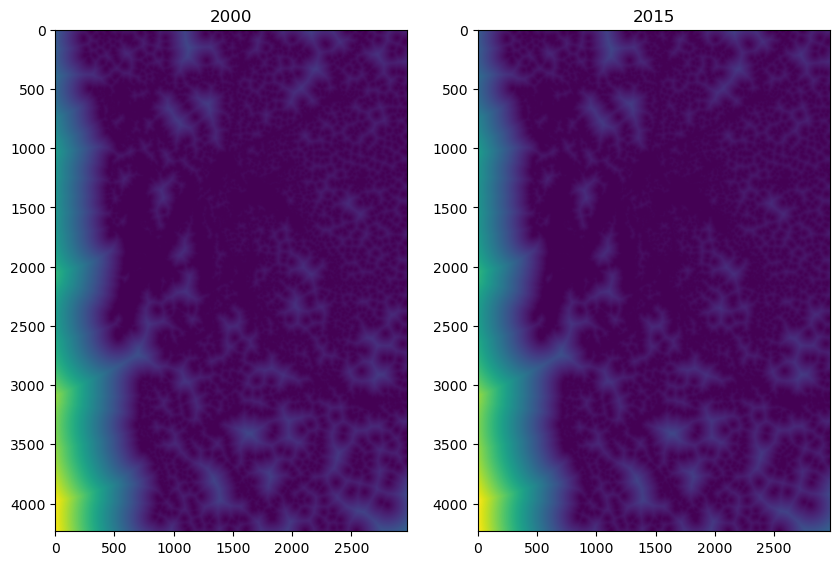

In [12]:
# let's plot it to have a look
plot_ras_ras(distance_buitup_2000, distance_buitup_2015, title1='2000', title2='2015', AOI_gdf = AOI_gdf)

### export them to tiff and ascii

In [14]:
# exporting as ASCII

# 2000 raster
raster_obj = distance_buitup_2000
export_path = interim_path/'MUM_URB_distance_urbanisation_2000_EOC_WUF_30m.asc'
ref_raster=ref_raster
raster_data_type=rasterio.float32
export_raster_to_ascii(raster_obj, export_path, ref_raster,raster_data_type)

# 2015 raster
raster_obj = distance_buitup_2015
export_path = interim_path/'MUM_URB_distance_urbanisation_2015_EOC_WUF_30m.asc'
ref_raster=ref_raster
raster_data_type=rasterio.float32
export_raster_to_ascii(raster_obj, export_path, ref_raster,raster_data_type)


## 4. Districts

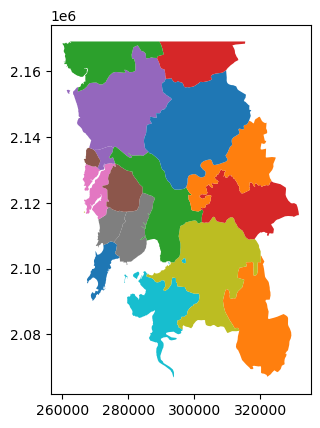

In [46]:
# import the GADM4 level 3 polygons from the shapefile

gadm_path = external_path / 'MUM_LIM_admin_boundaries_GADM4_MMR_A.shp'
gadm_gdf = gpd.read_file(gadm_path)

# clip the vectors to the AOI 
gadm_gdf_clipped = gadm_gdf.clip(AOI_gdf, keep_geom_type=True)
gadm_gdf_clipped.plot('NAME_3')

# convert 'NAME_3' to a sequential number
gadm_gdf_clipped['NAME_3'] = gadm_gdf_clipped['NAME_3'].astype('category')
gadm_gdf_clipped['NAME_3_num'] = gadm_gdf_clipped['NAME_3'].cat.codes
gadm_gdf_clipped.loc[gadm_gdf_clipped.NAME_3_num == 0, 'NAME_3_num'] = 21

In [47]:
gadm_gdf_clipped['NAME_3_num'].sort_values().unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21], dtype=int8)

In [48]:
# rasterize the clipped vectors
#gadm_raster = rasterise_vector(gadm_gdf_clipped, ref_raster, default_value)

df = gadm_gdf_clipped
col = 'NAME_3_num'
default_value = 0
dtype=rasterio.int16
ref_raster=ref_raster

if col:
    shapes = ((geom,value) for geom, value in zip(df.geometry, df[col]))
else: 
    shapes = df.geometry.values
    
varray = features.rasterize(shapes,
                   out_shape=ref_raster.shape,
                   transform=ref_raster.transform,
                   fill=0,
                   default_value=default_value,
                   all_touched=True,
                   dtype=dtype)



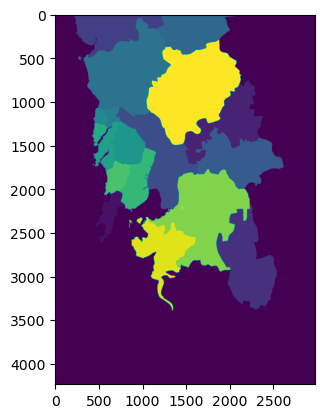

In [50]:
show(varray)
# export to ascii
export_path = interim_path/'MUM_LIM_districts_GADM4.asc'
ref_raster=ref_raster
raster_data_type=rasterio.int16
export_raster_to_ascii(varray, export_path, ref_raster,raster_data_type)

## 5. Tenure status
- Import 2016 slum clusters
- Convert to raster
- Ressample and co-register to 30 m grid

### import & rasterize

In [43]:
# importing the slum data, created by the MMRDA in 2016
slums_2016_vector = gpd.read_file(external_path / 'MUM_URB_slum_clusters_MMRDA_2016_A.shp')
ref_raster = rasterio.open(processed_path/ 'MUM_LIM_raster_reference_30m.tif','r')


In [29]:
# rasterizing the slum polygons
# script from https://pygis.io/docs/e_raster_rasterize.html

def rasterise_vector(vector, ref_raster, default_value):
    vector_geom = [shapes for shapes in vector.geometry]

    # when we rasterize the vector we already coregister to the reference raster
    raster = features.rasterize(vector_geom,
                                    out_shape = ref_raster.shape,
                                    fill = 0,
                                    out = None,
                                    transform = ref_raster.transform,
                                    all_touched = True,
                                    default_value = default_value,
                                    dtype = None)
    return raster

slums_2016_raster = rasterise_vector(slums_2016_vector, ref_raster, 1)

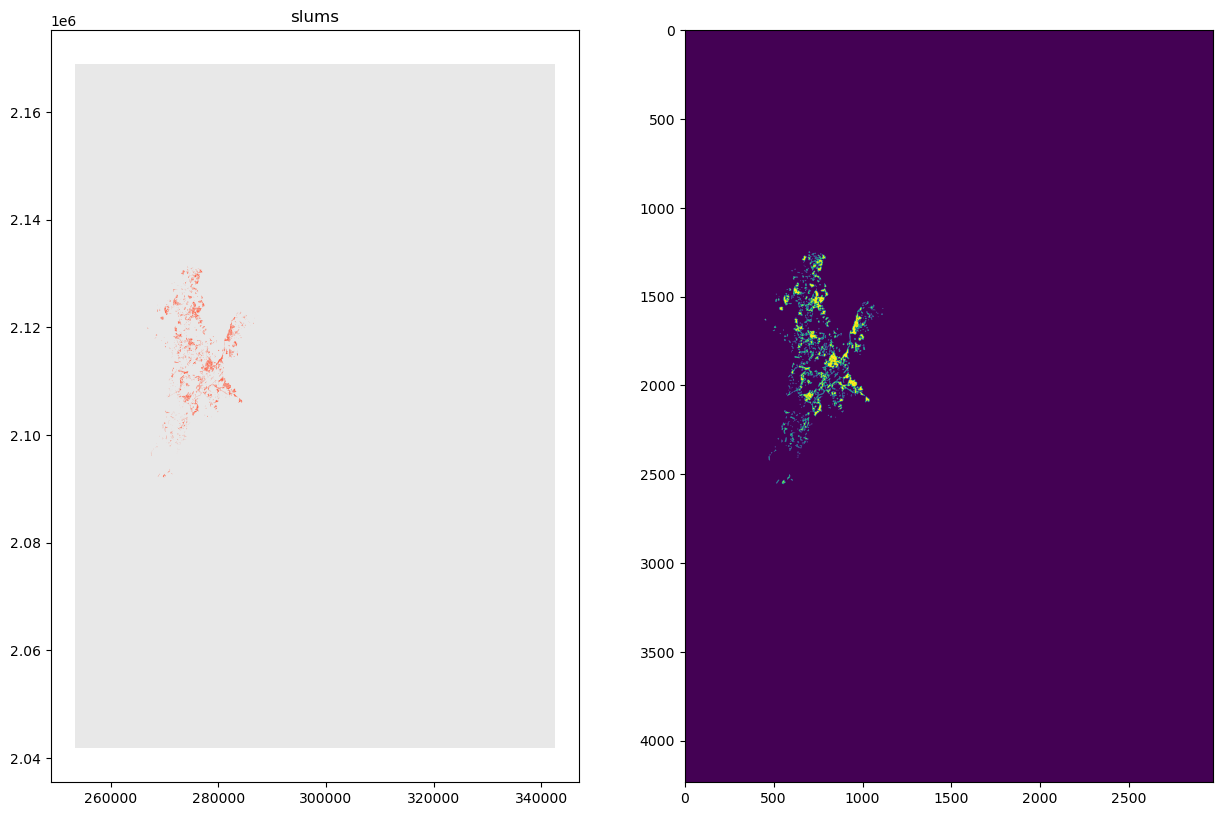

In [38]:
# plot to check the conversion
vector = slums_2016_vector
raster = slums_2016_raster
title = 'slums'

def plot_vec_ras(vector, raster, title):
    fig, ax = plt.subplots(nrows=1, ncols = 2, figsize = (15, 15))
    vector.plot(ax=ax[0],color='tomato', linewidth=1, zorder=2)
    AOI_gdf.plot(ax=ax[0],  alpha=0.5, color='lightgray', zorder=1)
    
    AOI_gdf.plot(ax=ax[1],  alpha=0.5, color='lightgray', zorder=1)
    show(raster, ax = ax[1])
    
    ax[0].set_title( title)
    #ax[0].set_axis_off()
    plt.gca() 
    plt.show()

plot_vec_ras(vector, raster, title)

### subtract from the urban areas to get full_tenure = 1 and no_tenure = 0

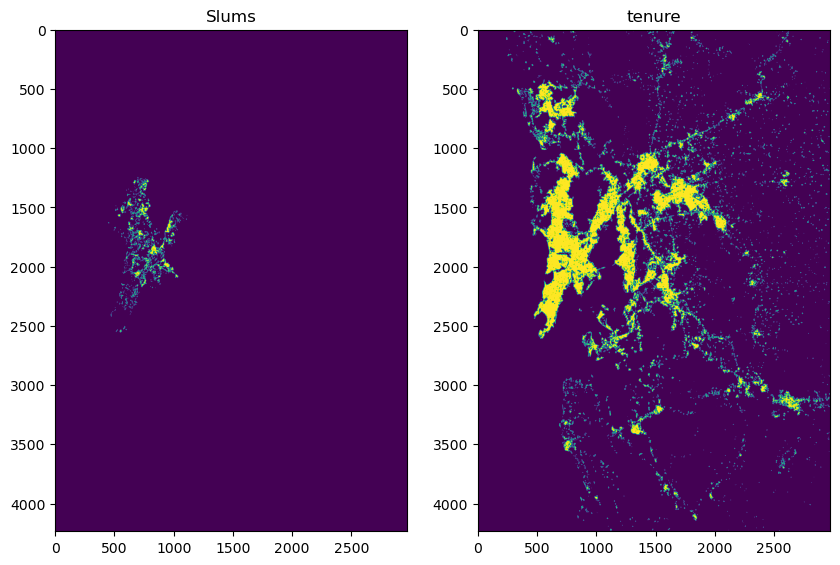

In [66]:
with rasterio.open(interim_path / 'MUM_URB_urbanisation_2015_EOC_WUF_30m.tif','r') as urban_raster:
    urban__areas = urban_raster.read(1)
    #urban_areas = np.where(urban__areas == 1, -1, urban__areas)
    tenure = urban__areas - slums_2016_raster
    tenure = np.where(tenure < 0, -9999, tenure)

plot_ras_ras(slums_2016_raster, tenure, 'Slums', 'tenure', AOI_gdf)

### export the raster

In [69]:
# export to GeoTIFF
data_type = rasterio.int16
raster = tenure
url = interim_path / 'MUM_URB_tenure_2016_MMRDA_30m.tif'
ref_raster = ref_raster

with rasterio.open(
    url, "w",
    driver = "GTiff",
    crs = ref_raster.crs,
    transform = ref_raster.transform,
    dtype = data_type,
    count = 1,
    width = ref_raster.width,
    height = ref_raster.height) as dst:
    dst.write(raster, indexes = 1)

In [70]:
# export to ASCII
export_raster_to_ascii(slums_2016_raster, 
                       interim_path/'MUM_URB_tenure_2016_MMRDA_30m.asc', 
                       ref_raster=ref_raster,
                       raster_data_type=rasterio.int16)

## 6. Exclusion layer
- Import water bodies
- Convert to raster
- Ressample and co-register to 30 m grid

In [ ]:
# calculate the exclusion layer
water_gdf = gpd.read_file(interim_path / 'MUM_HYD_Mumbai water bodies A.shp')
df_boundary_list = AOI_gdf['geometry'].bounds.values.tolist()[0]
water_gdf_clipped = gpd.clip(water_gdf, mask=df_boundary_list, keep_geom_type=True)
water_gdf_clipped['major'] = 1

water_geom = [shapes for shapes in water_gdf_clipped.geometry]

# rasterize the water bodies
water_raster = features.rasterize(water_geom,
                                    out_shape = ref_raster.shape,
                                    fill = 0,
                                    out = None,
                                    transform = ref_raster.transform,
                                    all_touched = True,
                                    default_value = 1,
                                    dtype = None)

plot_vec_vec_ras_ras(water_gdf_clipped, water_raster, water_raster, 'Exclusion layer')

water_path = interim_path / 'MUM_HYD_water_bodies_2024.asc'

export_raster_to_ascii(water_raster, water_path, rasterio.int16)


## 7. Attractiveness 2000 & 2020

- import OSM road information from OSMnX with the centrality measure.
- classify the top locations as a proxy for attractiveness.
- calculate the euclidian distance to these locations.

UNDER DEVELOPMENT

### implementing to Mumbai

In [19]:
aoi_bbox = AOI_gdf.to_crs(epsg='4326').bounds.values.tolist()[0]
MUM_graph = ox.graph.graph_from_bbox(bbox=aoi_bbox, 
                                     network_type="drive", 
                                     simplify=True, 
                                     retain_all=False, 
                                     truncate_by_edge=False, 
                                     clean_periphery=None, 
                                     custom_filter=None)


C:\Users\ra42zek\AppData\Local\Temp\ipykernel_10200\2066893047.py:2: FutureWarning: The expected order of coordinates in `bbox` will change in the v2.0.0 release to `(left, bottom, right, top)`.
  MUM_graph = ox.graph.graph_from_bbox(bbox=aoi_bbox,
c:\Users\ra42zek\AppData\Local\anaconda3\envs\x\Lib\site-packages\osmnx\_overpass.py:254: UserWarning: This area is 9,119 times your configured Overpass max query area size. It will automatically be divided up into multiple sub-queries accordingly. This may take a long time.
  multi_poly_proj = utils_geo._consolidate_subdivide_geometry(poly_proj)


In [ ]:
MUM_graph_bc = nx.betweenness_centrality(ox.convert.to_digraph(MUM_graph), weight="length")
max_node, max_bc = max(MUM_graph_bc.items(), key=lambda x: x[1])
nc = ["r" if node == max_node else "w" for node in MUM_graph.nodes]
ns = [80 if node == max_node else 15 for node in MUM_graph.nodes]
fig, ax = ox.plot_graph(MUM_graph, node_size=ns, node_color=nc, node_zorder=2)

## 8. Income 2000 and 2020 (not for Mumbai)
Currently lacking data source

## 9. Calculate distances to urban facilities

### fetch OSM data

#### Roads

##### fetch roads

In [ ]:
# get road LineStrings from OSM
# List key-value pairs for tags

tags = {'highway': ['primary', 'secondary', 'tertiary', 'residential', 'unclassified', 'trunk', 'motorway']} # more info at https://wiki.openstreetmap.org/wiki/Key:highway
col_list = ['osmid','name','source','geometry', 'highway','surface','lanes','incline'] #OSM has hundreds of cols, we just want a few. For info, check roads.columns
major_crit = {'highway': ['primary', 'secondary']} # when two keys are provided, the values are combined with an OR operator (i.e., union)
geom_type = 'LineString' # alternatives 'Point', 'LineString', 'Polygon', 'Mixed'

roads = get_osm_features(tags, col_list, geom_type, major_crit, AOI_gdf)

roads.plot('major',ax=AOI_gdf.plot(figsize=(10, 10),  alpha=0.5, color='lightgray'),cmap='Paired',  zorder=2) #linewidth=1,'place',

##### rasterize

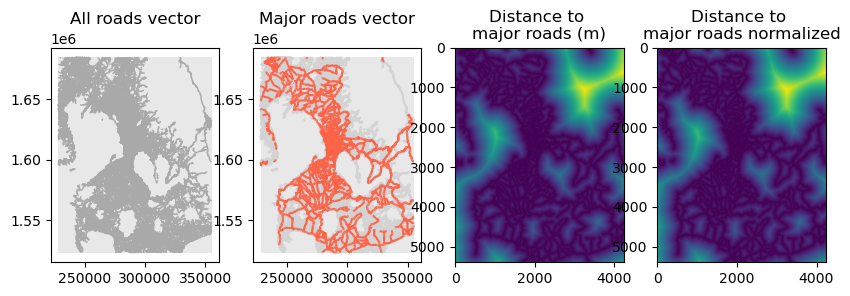

In [ ]:
# rasterize and calculate distances
roads_major_raster, roads_full_raster, roads_distance_raster, roads_dist_normalized = get_distance_raster(roads, ref_raster)

# Plot the outputs
plot_vec_vec_ras_ras(roads, roads_distance_raster, roads_dist_normalized, 'roads')



##### export roads

In [ ]:
#export_files(health, health_major_raster, health_full_raster, health_distance_raster, interim_path, 'MAN_TRA_health_OSM_2024')
export_files(roads, roads_major_raster, roads_full_raster, roads_distance_raster, roads_dist_normalized, interim_path, 'MAN_TRA_roads_OSM_2024')

#### health facilities

##### fetch health facilities

In [ ]:
# get health facility points from OSM
# List key-value pairs for tags
tags = {'healthcare': ['birthing_centre','centre', 'clinic', 'dentist', 'doctor','hospice','hospital','midwife','rehabilitation','yes'], # see https://wiki.openstreetmap.org/wiki/Key:healthcare for more info
        'amenity':['clinic','doctors','dentist','hospital']}  # see https://wiki.openstreetmap.org/wiki/Key:amenity for more info
col_list = ['osmid','name','geometry','amenity','healthcare'] #OSM has hundreds of cols, we just want a few. For info, check roads.columns'source',
major_crit = {'healthcare': ['hospital'],'amenity':['hospital']} # when two keys are provided, the values are combined with an OR operator (i.e., union)
geom_type = 'Point'

health = get_osm_features(tags, col_list, geom_type, major_crit, AOI_gdf)

health.plot('major',ax=AOI_gdf.plot(figsize=(10, 10),  alpha=0.5, color='lightgray'),cmap='Paired',  zorder=2) #linewidth=1,'place',

##### rasterize health

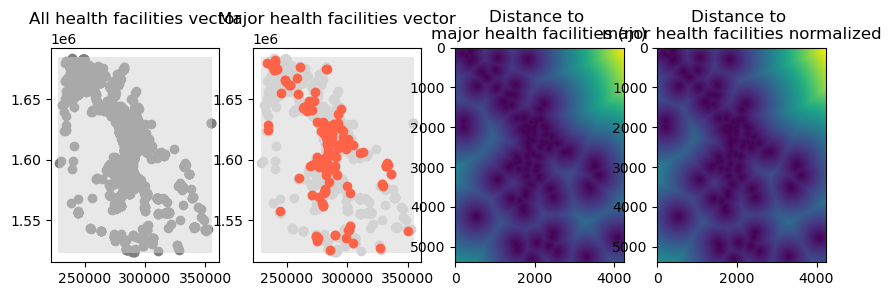

In [ ]:
# rasterize and calculate distances
health_major_raster, health_full_raster, health_distance_raster, health_dist_normalized = get_distance_raster(health, ref_raster)

# Plot the outputs
plot_vec_vec_ras_ras(health, health_distance_raster, health_dist_normalized, 'health facilities')

##### export health facilities

In [ ]:
export_files(health, health_major_raster, health_full_raster, health_distance_raster, health_dist_normalized, interim_path, 'MAN_LOC_health_OSM_2024')

#### schools

##### fetch schools

In [ ]:
# get schools points from OSM
# List key-value pairs for tags
tags = {'amenity': ['kindergarten','college', 'university', 'school','language_school','music_school','dancing_school','prep_school','training']} # see https://wiki.openstreetmap.org/wiki/Tag:amenity=school for more info
col_list = ['osmid','name','geometry','amenity', 'isced:level'] #OSM has hundreds of cols, we just want a few. For info, check roads.columns'source',
major_crit = {'amenity': ['college', 'university', 'school']}
geom_type = 'Point'

schools = get_osm_features(tags, col_list, geom_type, major_crit, AOI_gdf)
schools.plot('major',ax=AOI_gdf.plot(figsize=(10, 10),  alpha=0.5, color='lightgray'),cmap='Paired',  zorder=2) #linewidth=1,'place',

##### rasterize

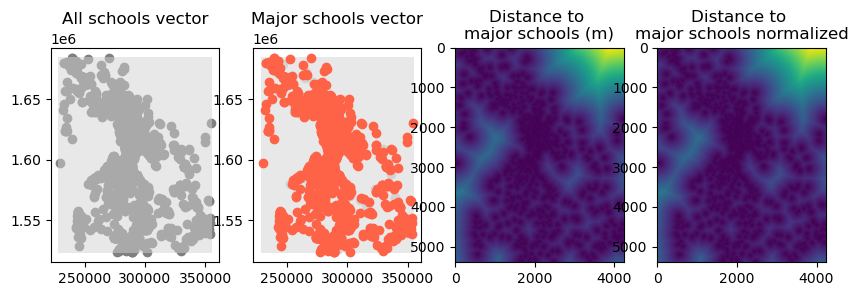

In [ ]:
# rasterize and calculate distances
schools_major_raster, schools_full_raster, schools_distance_raster, schools_dist_normalized = get_distance_raster(schools, ref_raster)

# Plot the outputs
plot_vec_vec_ras_ras(schools, schools_distance_raster, schools_dist_normalized, 'schools')

##### export schools

In [ ]:
export_files(schools, schools_major_raster, schools_full_raster, schools_distance_raster, schools_dist_normalized, interim_path, 'MAN_LOC_schools_OSM_2024')

#### suburban_centres

##### fetch suburban_centres

In [ ]:
# get health facility points from OSM
# List key-value pairs for tags
tags = {'place': ['town', 'village', 'hamlet']} # see https://wiki.openstreetmap.org/wiki/Key:place for more info, #'city',
col_list = ['osmid','name','geometry', 'place','population'] #OSM has hundreds of cols, we just want a few. For info, check roads.columns
major_crit = {'place':['town']} # other candidates'village', 'hamlet'
geom_type = 'Point'

suburbs = get_osm_features(tags, col_list, geom_type, major_crit, AOI_gdf)

#plot them
suburbs.plot('major',ax=AOI_gdf.plot(figsize=(10, 10),  alpha=0.5, color='lightgray'),cmap='Paired',  zorder=2) 

##### rasterize

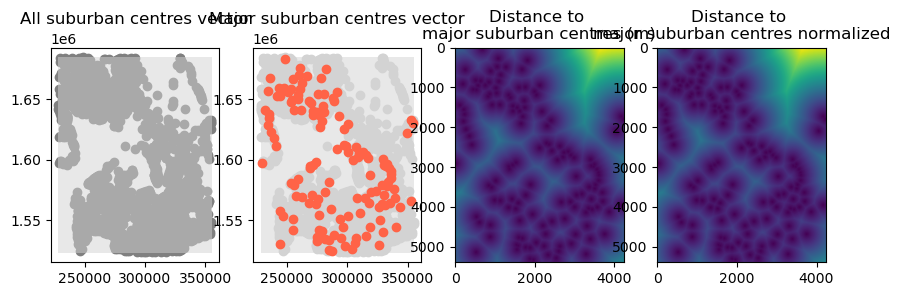

In [ ]:
# rasterize and calculate distances
suburbs_major_raster, suburbs_full_raster, suburbs_distance_raster, suburbs_dist_normalized = get_distance_raster(suburbs, ref_raster)

# Plot the outputs
plot_vec_vec_ras_ras(suburbs, suburbs_distance_raster, suburbs_dist_normalized, 'suburban centres')

##### export suburban_centres

In [ ]:
export_files(suburbs, suburbs_major_raster, suburbs_full_raster, suburbs_distance_raster,suburbs_dist_normalized, interim_path, 'MAN_LOC_suburban_centres_OSM_2024')

#### shopping_malls

##### fetch shopping_malls

In [ ]:
# get malls points from OSM
# List key-value pairs for tags
tags = {'shop': ['mall']} # see https://wiki.openstreetmap.org/wiki/Tag:shop%3Dmall for more info, #'city',
col_list = ['osmid','name','geometry','shop'] #OSM has hundreds of cols, we just want a few. For info, check roads.columns
major_crit = {'shop':['mall']}
geometry_type = 'Mixed'

malls = get_osm_features(tags, col_list, geom_type, major_crit, AOI_gdf)

malls.plot('major',ax=AOI_gdf.plot(figsize=(10, 10),  alpha=0.5, color='lightgray'),cmap='Paired',  zorder=2) 

##### rasterize

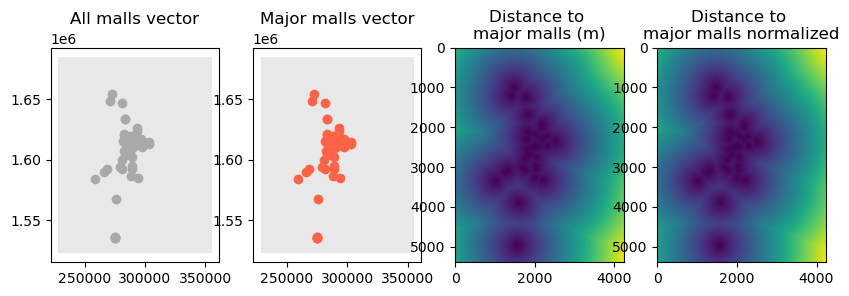

In [ ]:
# rasterize and calculate distances
malls_major_raster, malls_full_raster, malls_distance_raster, malls_dist_normalized = get_distance_raster(malls, ref_raster)

# Plot the outputs
plot_vec_vec_ras_ras(malls, malls_distance_raster, malls_dist_normalized, 'malls')

##### export shopping_malls

In [ ]:
#export_files(health, health_major_raster, health_full_raster, health_distance_raster, interim_path, 'MAN_TRA_health_OSM_2024')
export_files(malls, malls_major_raster, malls_full_raster, malls_distance_raster,malls_dist_normalized, interim_path, 'MAN_LOC_malls_OSM_2024')

#### markets

##### fetch markets

In [ ]:
# get health facility points from OSM
# List key-value pairs for tags
tags = {'amenity': ['marketplace']} # see https://wiki.openstreetmap.org/wiki/Key:place for more info, #'city',
col_list = ['osmid','name','geometry','amenity'] #OSM has hundreds of cols, we just want a few. For info, check roads.columns
major_crit = {'amenity':['marketplace']} 
geom_type = 'Mixed'

markets = get_osm_features(tags, col_list, geom_type, major_crit, AOI_gdf)

#plot them
markets.plot('major',ax=AOI_gdf.plot(figsize=(10, 10),  alpha=0.5, color='lightgray'),cmap='Paired',  zorder=2) 

##### rasterize

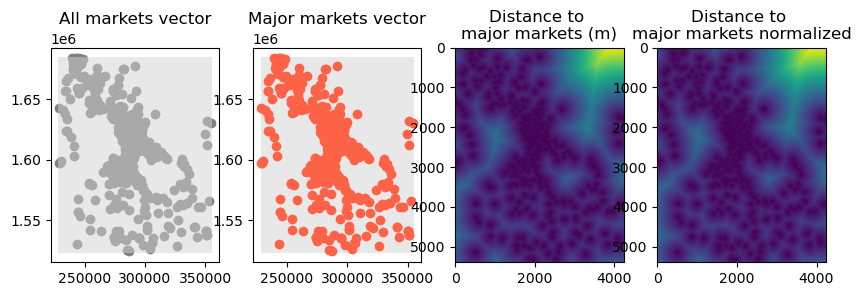

In [ ]:
# rasterize and calculate distances
markets_major_raster, markets_full_raster, markets_distance_raster, markets_dist_normalized = get_distance_raster(markets, ref_raster)

# Plot the outputs
plot_vec_vec_ras_ras(markets, markets_distance_raster, markets_dist_normalized, 'markets')

##### export markets

In [ ]:
export_files(markets, markets_major_raster, markets_full_raster, markets_distance_raster, markets_dist_normalized, interim_path, 'MAN_LOC_markets_OSM_2024')

#### airports

##### fetch airports

In [ ]:
tags = {'aeroway': ['aerodrome','airstrip']} # see https://wiki.openstreetmap.org/wiki/Tag:aeroway%3Daerodrome for more info, #'city',
col_list = ['osmid','name','geometry','aeroway','aerodrome:type'] #OSM has hundreds of cols, we just want a few. For info, check roads.columns
major_crit = {'aeroway': ['aerodrome']} 
geometry_type = 'Mixed'

airports = get_osm_features(tags, col_list, geom_type, major_crit, AOI_gdf)

#plot them
airports.plot('major',ax=AOI_gdf.plot(figsize=(10, 10),  alpha=0.5, color='lightgray'),cmap='Paired',  zorder=2) 

##### rasterize

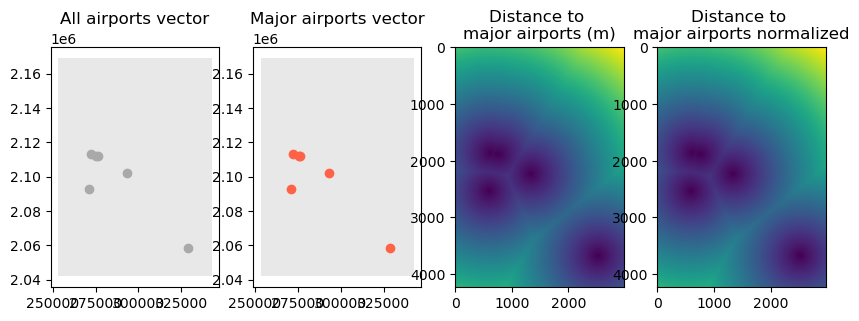

In [ ]:
# rasterize and calculate distances
airports_major_raster, airports_full_raster, airports_distance_raster, airports_dist_normalized = get_distance_raster(airports, ref_raster)

# Plot the outputs
plot_vec_vec_ras_ras(airports, airports_distance_raster, airports_dist_normalized, 'airports')

##### export airports

In [ ]:
export_files(airports, airports_major_raster, airports_full_raster, airports_distance_raster, airports_dist_normalized, interim_path, 'MAN_LOC_airports_OSM_2024')

#### CBDs

##### fetch CBDs

In [ ]:
# get health facility points from OSM
# List key-value pairs for tags
tags = {'landuse': ['commercial','retail','industrial']} # see https://wiki.openstreetmap.org/wiki/Key:place for more info, #'city',
col_list = ['osmid','name','geometry','landuse'] #OSM has hundreds of cols, we just want a few. For info, check roads.columns
# finding the CBDs is tricky as there is no official tag for it in OSM
# hence, we define a ad hoc list of OSM names for the areas that we consider as CBDs
# we researched it (see this post https://www.99acres.com/articles/the-cbds-in-MANbai.html) and validated locally.
name_list = ['CBD Belapur East','One BKC','Lodha Supremus','Peninsula Business Park','Tata Consultancy Services - TCS']  # other candidates: 'CIDCO Office - Kharghar', 
major_crit = {'name': name_list} 
geom_type = 'Mixed'

cbd = get_osm_features(tags, col_list, geom_type, major_crit, AOI_gdf)
cbd_selected = cbd.loc[cbd.name.isin(name_list),:]

#plot them
f = plt.figure(figsize=(10, 10))
ax=f.add_subplot(111)

#cbd.loc[(cbd.major==1),:].plot('major',ax=AOI_gdf.plot(figsize=(10, 10),  alpha=0.5, color='lightgray'),cmap='Paired', zorder=1)
ax.plot(cbd.centroid.x,cbd.centroid.y,'o',color='lightgrey', marker='o', zorder=2) #cmap='Paired',
AOI_gdf.plot(ax=ax,  alpha=0.5, color='lightgray', zorder=1)
ax.plot(cbd_selected.centroid.x,cbd_selected.centroid.y, 'ro', zorder=3)
plt.show()

##### rasterize

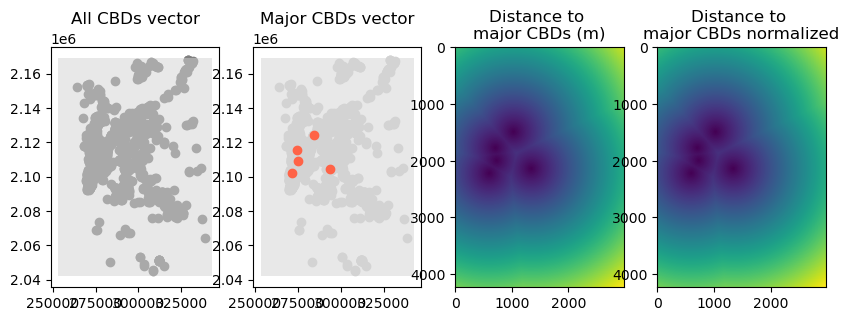

In [ ]:
# rasterize and calculate distances
cbd_major_raster, cbd_full_raster, cbd_distance_raster, cbd_dist_normalized = get_distance_raster(cbd, ref_raster)

# Plot the outputs
plot_vec_vec_ras_ras(cbd, cbd_distance_raster, cbd_dist_normalized, 'CBDs')

##### export CBDs

In [ ]:
export_files(cbd, cbd_major_raster, cbd_full_raster, cbd_distance_raster,cbd_dist_normalized, interim_path, 'MAN_LOC_CBDs_OSM_2024')

# Processing other rasters and exporting to ASCII

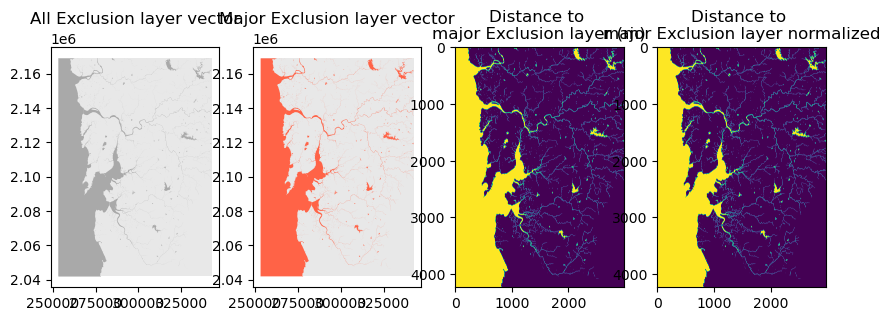

In [ ]:
# calculate the exclusion layer
water_gdf = gpd.read_file(interim_path / 'MAN_HYD_MANbai water bodies A.shp')
df_boundary_list = AOI_gdf['geometry'].bounds.values.tolist()[0]
water_gdf_clipped = gpd.clip(water_gdf, mask=df_boundary_list, keep_geom_type=True)
water_gdf_clipped['major'] = 1

water_geom = [shapes for shapes in water_gdf_clipped.geometry]

# rasterize the water bodies
water_raster = features.rasterize(water_geom,
                                    out_shape = ref_raster.shape,
                                    fill = 0,
                                    out = None,
                                    transform = ref_raster.transform,
                                    all_touched = True,
                                    default_value = 1,
                                    dtype = None)

plot_vec_vec_ras_ras(water_gdf_clipped, water_raster, water_raster, 'Exclusion layer')

water_path = interim_path / 'MAN_HYD_water_bodies_2024.asc'

export_raster_to_ascii(water_raster, water_path, rasterio.int16)
